# Cleaning data: removing blur

The $NO_2$ data is in principle very useful in estimating traffic. However, $NO_2$ is subject to weather. Wind will carry $NO_2$ over large distances, and rain will wash it out of the atmosphere. To be able to estimate traffic using $NO_2$ data, we will need to account for these distortions. 

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.ndimage as scn
import scipy.signal as scs
import scipy.fftpack as scf
import netCDF4 as nc

Looking at the data, it is hard to make out any single pointsources of $NO_2$. Wheather has blurred our measurements. 

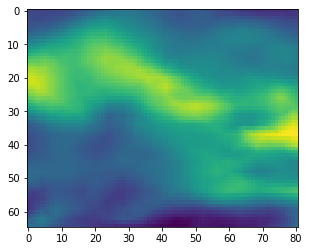

In [20]:
dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")['tcno2']

data = dataMarch1918[1]
plt.imshow(data)

Note, however, that this blur is not exactly a Gaussian blur. Even though we are looking at the data from a large distance, it seems that generally wind is moving $NO_2$ in a more or less consistant direction at every pixel. The kind of blur we are dealing with here is not very different from motion blur. 

That is forunate for us, because motion blur is easily modelled with a simple convolution.

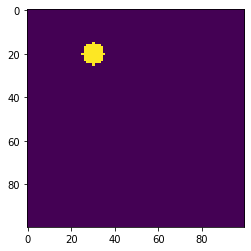

In [2]:
def distance(v1, v2):
    x1, y1 = v1
    x2, y2 = v2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def pointMtrx(R, C, cx, cy, rad):
    mtrx = np.zeros((R, C))
    for r in range(R):
        for c in range(C):
            if distance((r, c), (cx, cy)) <= rad:
                mtrx[r, c] = 1
    return mtrx


plt.imshow(pointMtrx(100, 100, 20, 30, 5))

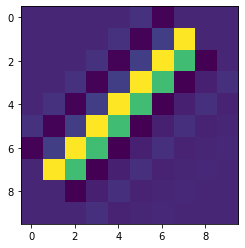

In [3]:
def motionBlurKernel(degrees, n):

    # rotated line
    c = int((n-1)/2)
    kernel = np.zeros((n, n))
    kernel[c, :] = np.ones(n)
    kernel = scn.rotate(kernel, degrees)

    # crop
    N, _ = kernel.shape
    delta = int((N - n) / 2)
    if delta > 0:
        kernel = kernel[delta:-delta, delta:-delta]
    
    # normalize
    kernel = kernel / np.sum(kernel)
    return kernel

m = motionBlurKernel(45, 10)
plt.imshow(m)

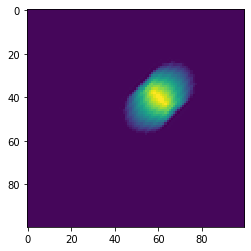

In [14]:
pt = pointMtrx(100, 100, 40, 60, 10)
mbk = motionBlurKernel(45, 20)
plt.imshow(scs.convolve2d(pt, mbk, 'same'))

As you can see, it was not hard to create a simple motion-blur effect with one single convolution operation. 
Convolutions are nice to work with, because in principle they can be undone again, using a process often called *deconvolution*.

Text(0.5, 1.0, 'reconstructed')

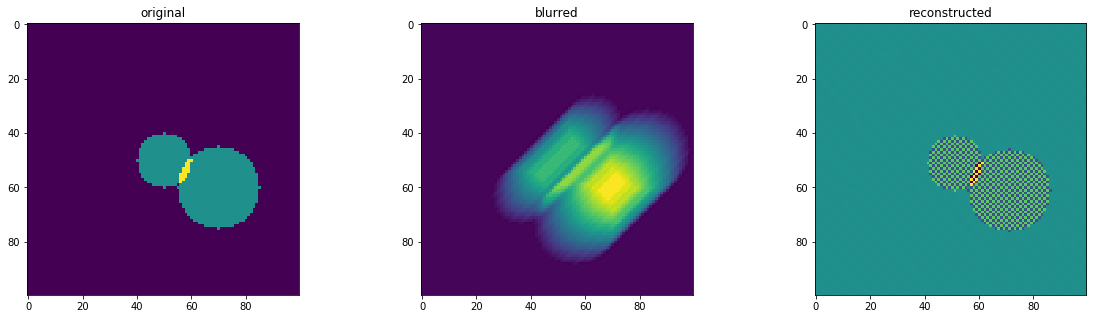

In [25]:
def centerPad(kernel, n):
    l, _ = kernel.shape
    m = np.zeros((n, n))
    delta = int((n - l) / 2)
    m[delta:delta+l, delta:delta+l] = kernel
    return m

def filterMotionBlur(image, angle, width):
    L, _ = image.shape
    kernel = motionBlurKernel(angle, width)
    kernel_p = centerPad(kernel, L)
    F_image = scf.fftshift( np.fft.fft2(image) )
    F_kernel = scf.fftshift( np.fft.fft2(kernel_p) )
    F_reconstr = F_image / F_kernel
    reconstr = scf.ifftshift( np.fft.ifft2(F_reconstr) )
    return reconstr



# image
point = pointMtrx(100, 100, 50, 50, 10)
point += pointMtrx(100, 100, 60, 70, 15)
noiseK = motionBlurKernel(45, 40)
image = scs.convolve2d(point, noiseK, 'same')

# reconstruction
pointReconstr = filterMotionBlur(image, 45, 40)

# #plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(point)
axes[0].set_title('original')
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[2].imshow(np.real(pointReconstr))
axes[2].set_title('reconstructed')

The image above shows that we can - in principle - easily undo a motion-blur effect. This requires that we know the kernel, in this case the motion-blur-filter. If, however, we make even a small mistake in our kernel (in this case, say, using a blur-angle of `50` instead of `45` degrees), the reconstruction looks terrible:

Text(0.5, 1.0, 'reconstructed')

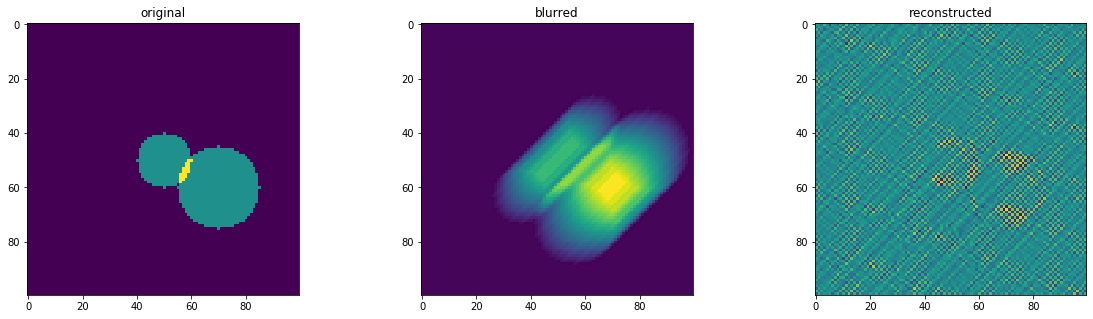

In [29]:

# reconstruction
pointReconstr = filterMotionBlur(image, 50, 40)

# #plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(point)
axes[0].set_title('original')
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[2].imshow(np.real(pointReconstr))
axes[2].set_title('reconstructed')

Let's see how well our function does with real data.

Text(0.5, 1.0, 'deconvolved data')

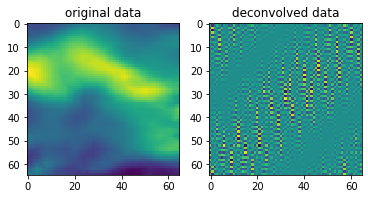

In [30]:
R, C = data.shape
data_sq = data[:, :R]
# we're just estimating that the wind direction is around 160 degrees, streching pointsources by 10 pixels.
data_clean = filterMotionBlur(data_sq, 160, 10)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(data_sq)
ax[0].set_title('original data')
ax[1].imshow(np.real(data_clean))
ax[1].set_title('deconvolved data')

Ouch! Clearly our naive approach does not work very well when we are dealing with more complicated data. Indeed, deconvolution is notoriously sensitive to even smaller numeric aberations.